In [2]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import tqdm

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from itertools import chain

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import detection_utils as utils
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from collections import OrderedDict
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
    build_detection_train_loader,
    build_detection_test_loader,
    DatasetMapper
)
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.modeling import build_model

1.9.0+cu102 True


In [3]:
# Register the datasets
def get_data(dataroot, file_name):
    def ret_data():
        output_path = os.path.join(dataroot, file_name)
        print(output_path)
        assert os.path.exists(output_path)
        with open(output_path, 'r') as fd:
            data = json.load(fd)
        fd.close()
        return data
    return ret_data

In [4]:
dataroot = '/usr0/tma1/datasets/nuimages/detectron_data'
train_file = 'v1.0-train_trafficcone_detectron.json'
val_file = 'val_val_trafficcone_detectron.json'
test_file = 'val_test_trafficcone_detectron.json'

In [5]:
category_dict = {0: 'traffic_cones'}
data_train = DatasetCatalog.register("nuimages_train_trafficone", get_data(dataroot, train_file))
MetadataCatalog.get("nuimages_train_trafficone").thing_classes = category_dict
data_val = DatasetCatalog.register("nuimages_val_trafficone", get_data(dataroot, val_file))
MetadataCatalog.get("nuimages_val_trafficone").thing_classes = category_dict
data_test = DatasetCatalog.register("nuimages_test_trafficone", get_data(dataroot, test_file))
MetadataCatalog.get("nuimages_test_trafficone").thing_classes = category_dict

In [10]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%H-%M-%S")
ckpt_date_time = '2021-10-26-01-38-57'
gt_folder = '/usr0/tma1/datasets/nuimages/detectron_data'

In [11]:
# Parameters
show_image=False
output_dir='/usr0/tma1/datasets/nuimages/object_detection_annotations'
predicted_dir='/usr0/tma1/traffic_cone_detection/output'
visualize_dataset_name = 'nuimages_test_trafficone'
split = 'test'

if not os.path.exists(os.path.join(predicted_dir, date_time)):
    os.mkdir(os.path.join(predicted_dir, date_time))

predicted_output_folder = os.path.join(os.path.join(predicted_dir, date_time), 'predicted_output')
if not os.path.exists(predicted_output_folder):
    os.mkdir(predicted_output_folder)
    
prediction_name = date_time + '_' + visualize_dataset_name
predicted_output_folder = os.path.join(predicted_output_folder, prediction_name)
if not os.path.exists(predicted_output_folder):
    os.mkdir(predicted_output_folder)
    
output_folder = os.path.join(os.path.join(predicted_dir, date_time), 'evaluation_output')
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

output_split_folder = os.path.join(output_folder, visualize_dataset_name)
if not os.path.exists(output_split_folder):
    os.mkdir(output_split_folder)

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# Modified configurations
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
# cfg.MODEL.DEVICE='cpu'

cfg.DATASETS.TRAIN = ("nuimages_train_trafficone",)
cfg.DATASETS.TEST = ("nuimages_test_trafficone",)

cfg.OUTPUT_DIR = os.path.join('/usr0/tma1/traffic_cone_detection/output', ckpt_date_time)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0076499.pth")
# model = build_model(cfg)
predictor = DefaultPredictor(cfg)

In [14]:
def format_instance(instance, category_dict):
    class_name = category_dict[instance.get('pred_classes').data.cpu().numpy()[0]]
    pred_boxes = instance.get('pred_boxes').tensor.data.cpu().numpy()[0]
    score = instance.get('scores').data.cpu().numpy()[0]
    return '{} {} {} {} {} {}'.format(class_name, score, int(pred_boxes[0]), int(pred_boxes[1]), int(pred_boxes[2]), int(pred_boxes[3]))

In [60]:
percentage = []
area = []
iou = []

In [61]:
def get_iou(b1, b2):
    x_left = max(b1[0], b2[0])
    x_right = min(b1[2], b2[2])
    y_top = max(b1[1], b2[1])
    y_bottom = min(b1[3], b2[3])
    
    if (x_right < x_left or y_bottom < y_top):
        return 0.0
    
    b1_area = (b1[2] - b1[0]) * (b1[3] - b1[1])
    b2_area = (b2[2] - b2[0]) * (b2[3] - b2[1])
    
    return ((x_right - x_left) * (y_bottom - y_top)) / (b1_area + b2_area)

In [62]:
dicts = list(chain.from_iterable([DatasetCatalog.get(k) for k in [visualize_dataset_name]]))
metadata = MetadataCatalog.get(visualize_dataset_name)
print(visualize_dataset_name)

for dic in tqdm.tqdm(dicts):
    im = utils.read_image(dic["file_name"], "RGB")
    outputs = predictor(im)
    for i in range(len(outputs['instances'])):
        instance = outputs['instances'][i]
        pred_boxes = instance.get('pred_boxes')
        # from pdb import set_trace as bp; bp()
        # Compute iou
#         for j in range(i+1, len(outputs['instances'])):
#             b1 = pred_boxes.tensor.data.cpu().numpy()[0]
#             b2 = outputs['instances'][j].get('pred_boxes').tensor.data.cpu().numpy()[0]
#             iou = get_iou(b1, b2)
#             assert iou <= 0.5
            
        area.append(pred_boxes.area().data.cpu().numpy()[0])
        percentage.append(instance.get('scores').data.cpu().numpy()[0])

/usr0/tma1/datasets/nuimages/detectron_data/val_test_trafficcone_detectron.json
nuimages_test_trafficone


  0%|          | 0/2263 [00:00<?, ?it/s]/usr1/home/tma1/Desktop/venv/lib/python3.6/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr1/home/tma1/Desktop/venv/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, paddi

KeyboardInterrupt: 

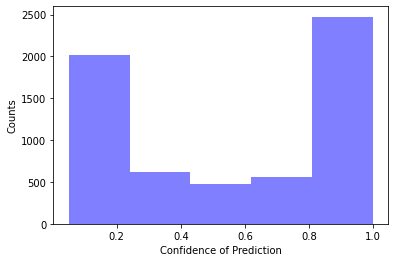

In [44]:
import matplotlib.pyplot as plt
num_bins = 5
n, bins, patches = plt.hist(percentage, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel("Confidence of Prediction")
plt.ylabel("Counts")
plt.show()

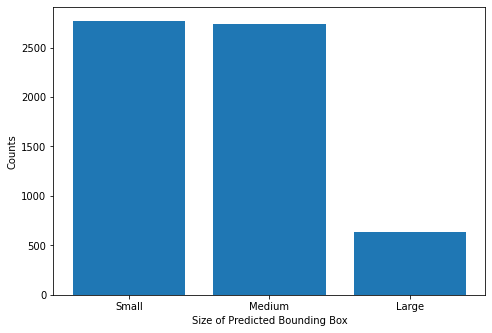

In [45]:
import matplotlib.pyplot as plt
area_a = np.array(area)
small_cond = np.bitwise_and(area_a>0, area_a<=(32**2))
small_count = len(np.where(small_cond)[0])

med_cond = np.bitwise_and(area_a>(32**2), area_a<=(96**2))
med_count = len(np.where(med_cond)[0])

large_cond = area_a > (96**2)
larege_count = len(np.where(large_cond)[0])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Small', 'Medium', 'Large']
students = [small_count, med_count, larege_count]
ax.bar(langs,students)
plt.xlabel("Size of Predicted Bounding Box")
plt.ylabel("Counts")
plt.show()

In [46]:
print(len(area))

6145


In [15]:
dicts = list(chain.from_iterable([DatasetCatalog.get(k) for k in [visualize_dataset_name]]))
metadata = MetadataCatalog.get(visualize_dataset_name)
print(visualize_dataset_name)

for dic in tqdm.tqdm(dicts):
    im = utils.read_image(dic["file_name"], "RGB")
    outputs = predictor(im)
    predictions = []

    for i in range(len(outputs['instances'])):
        predictions.append(format_instance(outputs['instances'][i], category_dict))
    
    img_name = dic["file_name"].split('/')[-1]
    txt_name = img_name.split('.')[0] + '.txt'
    txt_name = os.path.join(output_split_folder, txt_name)
    
    # Write result to folder
    with open(txt_name, 'w+') as fd:
        fd.write('\n'.join(predictions))

/usr0/tma1/datasets/nuimages/detectron_data/val_test_trafficcone_detectron.json
nuimages_test_trafficone


 16%|█▌        | 367/2263 [00:35<03:02, 10.38it/s]


KeyboardInterrupt: 

Create ground truth formats

In [71]:
gt_eval = '/usr0/tma1/datasets/nuimages/detectron_data/evaluation_ground_truth'
gt_eval_split = os.path.join(gt_eval, visualize_dataset_name)
if not os.path.exists(gt_eval_split):
    os.mkdir(gt_eval_split)

with open(os.path.join(dataroot, val_file), 'r') as fd:
    data = json.load(fd)
    i = 0;
    for d in tqdm.tqdm(data):
        i += 1
        img_name = d['file_name'].split('/')[-1]
        txt_name = img_name.split('.')[0] + '.txt'
        annotation = []
        for anno in d['annotations']:
            pred_boxes = anno['bbox']
            class_name = category_dict[anno['category_id']]
            rslt = '{} {} {} {} {}'.format(class_name, pred_boxes[0], pred_boxes[1], pred_boxes[2], pred_boxes[3])
            annotation.append(rslt)
        
        out_file = os.path.join(gt_eval_split, txt_name)
        with open(out_file, 'w+') as fd:
            fd.write('\n'.join(annotation))

100%|██████████| 2263/2263 [00:00<00:00, 30553.08it/s]


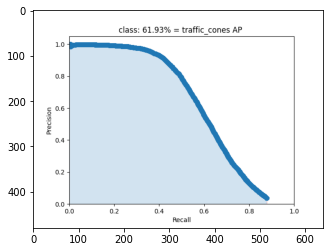

In [53]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/home/tma1/Desktop/construction_detection/mAP/output/classes/traffic_cones.png')
imgplot = plt.imshow(img)
plt.show()

In [72]:
gt = []
pred = []

gt_folder = '/usr0/tma1/datasets/nuimages/detectron_data/evaluation_ground_truth/nuimages_test_trafficone/'

# [xmin, ymin, xmax, ymax, class_id, difficult, crowd]
for file in os.listdir(gt_folder):
    fd = open(os.path.join(gt_folder, file), 'r')
    line = fd.readline()
    per_im = []
    while (line):
        a = line.split(' ')
        per_im.append([int(float(a[1])), int(float(a[2])), int(float(a[3])), int(float(a[4])), 0, 0, 0])
        line = fd.readline()
    gt.append(np.array(per_im))

pred_folder = '/usr0/tma1/traffic_cone_detection/output/2021-10-26-01-38-57/evaluation_output/nuimages_test_trafficone/'

# [xmin, ymin, xmax, ymax, class_id, confidence]
for file in os.listdir(pred_folder):
    fd = open(os.path.join(pred_folder, file), 'r')
    try:
        line = fd.readline()
    except:
        pred.append(np.array([]))
        continue
        
    per_im = []
    while (line):
        a = line.split(' ')
        per_im.append([int(float(a[2])), int(float(a[3])), int(float(a[4])), int(float(a[5])), 0, float(a[1])])
        line = fd.readline()
    pred.append(np.array(per_im))


In [73]:
gt = np.array(gt)
pred = np.array(pred)

/usr1/home/tma1/Desktop/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr1/home/tma1/Desktop/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [77]:
from mean_average_precision import MetricBuilder

metric_fn = MetricBuilder.build_evaluation_metric("map_2d", async_mode=True, num_classes=1)
print(len(gt), len(pred))
for i in range(1):
    print(pred[i], gt[i])
    metric_fn.add(pred[i], gt[i])

print(f"COCO mAP: {metric_fn.value(iou_thresholds=np.arange(0.5, 1.0, 0.05), recall_thresholds=np.arange(0., 1.01, 0.01), mpolicy='soft')['mAP']}")

2263 2263
[[1.51700000e+03 5.82000000e+02 1.57200000e+03 6.58000000e+02
  0.00000000e+00 9.98020530e-01]
 [1.44300000e+03 5.92000000e+02 1.50000000e+03 6.85000000e+02
  0.00000000e+00 9.93436098e-01]
 [5.82000000e+02 5.44000000e+02 5.93000000e+02 5.66000000e+02
  0.00000000e+00 4.36525643e-01]
 [6.24000000e+02 5.42000000e+02 6.35000000e+02 5.65000000e+02
  0.00000000e+00 5.44677675e-02]] [[562 467 600 537   0   0   0]]
COCO mAP: 0.0


In [45]:
results = OrderedDict()
for dataset_name in cfg.DATASETS.TEST:
    data_loader = build_detection_test_loader(cfg, dataset_name)
    dataset_name = cfg.DATASETS.TEST[0]
    evaluator = COCOEvaluator(dataset_name, tasks=["bbox"], output_dir=cfg.OUTPUT_DIR)
    model = model.eval()
    with torch.no_grad():
        def get_all_inputs_outputs():
          for data in data_loader:
            yield data, model(data)

        for inputs, outputs in get_all_inputs_outputs():
          evaluator.process(inputs, outputs)
        eval_results = evaluator.evaluate()

/usr0/tma1/datasets/nuimages/detectron_data/val_val_trafficcone_detectron.json
[11/01 18:58:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/01 18:58:56 d2.data.common]: Serializing 2263 elements to byte tensors and concatenating them all ...
[11/01 18:58:56 d2.data.common]: Serialized dataset takes 0.82 MiB
[11/01 19:01:03 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/01 19:01:03 d2.evaluation.coco_evaluation]: Saving results to /usr0/tma1/traffic_cone_detection/output/2021-10-26-01-38-57/coco_instances_results.json
[11/01 19:01:03 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[11/01 19:01:03 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[11/01 19:01:03 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() 